In [1]:
import numpy as np
import matplotlib.pyplot as plt

START with a simple reaction:
A->B:
a. dB/dt=-dA/dt=k[A]
b. [A]=[A]t0 * e^(-kt)



In [2]:
#first set up timescale
seconds=np.arange(0,10*60,1)

In [3]:
Ainit=10e-6
k=1e-2

(0.0, 1e-05)

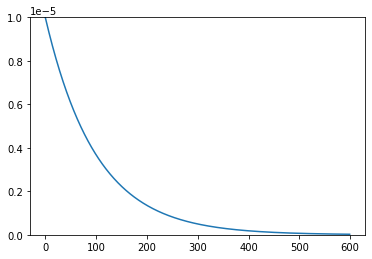

In [4]:
A=Ainit*np.exp(-k*seconds)
plt.plot(seconds,A)
plt.ylim(0,Ainit)

In [17]:
seconds

array([0])

In [8]:
import panel as pn
pn.extension()

In [6]:
float_slider = pn.widgets.FloatSlider(name='Float Slider', start=0, end=3.141, step=0.01, value=1.57)

In [9]:
float_slider

Traceback (most recent call last):
 File "C:\Users\kvand\kvmcode\thermoviz\venv_thermoviz\lib\site-packages\pyviz_comms\__init__.py", line 325, in _handle_msg
 self._on_msg(msg)
 File "C:\Users\kvand\kvmcode\thermoviz\venv_thermoviz\lib\site-packages\panel\viewable.py", line 261, in _on_msg
 doc.unhold()
 File "C:\Users\kvand\kvmcode\thermoviz\venv_thermoviz\lib\site-packages\bokeh\document\document.py", line 669, in unhold
 self._trigger_on_change(event)
 File "C:\Users\kvand\kvmcode\thermoviz\venv_thermoviz\lib\site-packages\bokeh\document\document.py", line 1180, in _trigger_on_change
 self._with_self_as_curdoc(event.callback_invoker)
 File "C:\Users\kvand\kvmcode\thermoviz\venv_thermoviz\lib\site-packages\bokeh\document\document.py", line 1198, in _with_self_as_curdoc
 return f()
 File "C:\Users\kvand\kvmcode\thermoviz\venv_thermoviz\lib\site-packages\bokeh\util\callback_manager.py", line 161, in invoke
 callback(attr, old, new)
 File "C:\Users\kvand\kvmcode\thermoviz\venv_thermoviz\lib\site-packages\panel\reactive.py", line 273, in _comm_change
 self._process_events({attr: new})
 File "C:\Users\kvand\kvmcode\thermoviz\venv_thermoviz\lib\site-packages\panel\reactive.py", line 245, in _process_events
 self.param.set_param(**self._process_property_change(events))
 File "C:\Users\kvand\kvmcode\thermoviz\venv_thermoviz\lib\site-packages\param\parameterized.py", line 1526, in set_param
 self_._batch_call_watchers()
 File "C:\Users\kvand\kvmcode\thermoviz\venv_thermoviz\lib\site-packages\param\parameterized.py", line 1665, in _batch_call_watchers
 self_._execute_watcher(watcher, events)
 File "C:\Users\kvand\kvmcode\thermoviz\venv_thermoviz\lib\site-packages\param\parameterized.py", line 1627, in _execute_watcher
 watcher.fn(*args, **kwargs)
TypeError: cool() takes 0 positional arguments but 1 was given
 


 Traceback (most recent call last):
 File "C:\Users\kvand\kvmcode\thermoviz\venv_thermoviz\lib\site-packages\pyviz_comms\__init__.py", line 325, in _handle_msg
 self._on_msg(msg)
 File "C:\Users\kvand\kvmcode\thermoviz\venv_thermoviz\lib\site-packages\panel\viewable.py", line 261, in _on_msg
 doc.unhold()
 File "C:\Users\kvand\kvmcode\thermoviz\venv_thermoviz\lib\site-packages\bokeh\document\document.py", line 669, in unhold
 self._trigger_on_change(event)
 File "C:\Users\kvand\kvmcode\thermoviz\venv_thermoviz\lib\site-packages\bokeh\document\document.py", line 1180, in _trigger_on_change
 self._with_self_as_curdoc(event.callback_invoker)
 File "C:\Users\kvand\kvmcode\thermoviz\venv_thermoviz\lib\site-packages\bokeh\document\document.py", line 1198, in _with_self_as_curdoc
 return f()
 File "C:\Users\kvand\kvmcode\thermoviz\venv_thermoviz\lib\site-packages\bokeh\util\callback_manager.py", line 161, in invoke
 callback(attr, old, new)
 File "C:\Users\kvand\kvmcode\thermoviz\venv_thermoviz\lib\site-packages\panel\reactive.py", line 273, in _comm_change
 self._process_events({attr: new})
 File "C:\Users\kvand\kvmcode\thermoviz\venv_thermoviz\lib\site-packages\panel\reactive.py", line 245, in _process_events
 self.param.set_param(**self._process_property_change(events))
 File "C:\Users\kvand\kvmcode\thermoviz\venv_thermoviz\lib\site-packages\param\parameterized.py", line 1526, in set_param
 self_._batch_call_watchers()
 File "C:\Users\kvand\kvmcode\thermoviz\venv_thermoviz\lib\site-packages\param\parameterized.py", line 1665, in _batch_call_watchers
 self_._execute_watcher(watcher, events)
 File "C:\Users\kvand\kvmcode\thermoviz\venv_thermoviz\lib\site-packages\param\parameterized.py", line 1627, in _execute_watcher
 watcher.fn(*args, **kwargs)
TypeError: cool() takes 0 positional arguments but 1 was given
 


 Traceback (most recent call last):
 File "C:\Users\kvand\kvmcode\thermoviz\venv_thermoviz\lib\site-packages\pyviz_comms\__init__.py", line 325, in _handle_msg
 self._on_msg(msg)
 File "C:\Users\kvand\kvmcode\thermoviz\venv_thermoviz\lib\site-packages\panel\viewable.py", line 261, in _on_msg
 doc.unhold()
 File "C:\Users\kv

FloatSlider(end=3.141, name='Float Slider', step=0.01, value=1.57)

In [16]:
from bokeh.plotting import figure

p1 = figure(width=300, height=300)
A=Ainit*np.exp(-float_slider.value*seconds)
p1.line(seconds,A )
pnl=pn.panel(p1)
pnl.link(float_slider,)
#tabs = pn.Tabs(p1)
pnl

ValueError: Declare parameters to link or a set of callbacks, neither was defined.

In [25]:
float_slider.param.watch(cool, 'value')

Watcher(inst=FloatSlider(end=3.141, name='Float Slider', step=0.01, value=1.6), cls=<class 'panel.widgets.slider.FloatSlider'>, fn=<function cool at 0x000001F4B7A85700>, mode='args', onlychanged=True, parameter_names=('value',), what='value', queued=False)

In [26]:
def cool(thin):
    p1 = figure(width=300, height=300)
    A=Ainit*np.exp(-float_slider.value*seconds)
    p1.line(seconds,A )
    pnl=pn.panel(p1)
#    pnl.link(float_slider,)
#tabs = pn.Tabs(p1)
    return pnl

In [1]:
import numpy as np
from chempy import ReactionSystem

In [11]:
rxnstr=""" A + B -> C; 1e-4 
            C -> A + B ; 1e-1 """

In [34]:
from chempy import Reaction

In [ ]:
r=Reaction()

In [26]:
>>> rsys = ReactionSystem.from_string("""2 Fe+2 + H2O2 -> 2 Fe+3 + 2 OH-; 42
...     2 Fe+3 + H2O2 -> 2 Fe+2 + O2 + 2 H+; 17
...     H+ + OH- -> H2O; 1e10
...     H2O -> H+ + OH-; 1e-4""")

In [33]:
rsys=ReactionSystem.from_string("""A + B -> C; 1e-4
...     C -> A + B; 1e-1""",\
    substances=['A','B','C'])

ParseException: Expected {Re:('A[cglmrstu]|B[aehikr]?|C[adeflmnorsu]?|D[bsy]|E[rsu]|F[elmr]?|G[ade]|H[efgos]?|I[nr]?|Kr?|L[airuv]|M[cdgnot]|N[abdehiop]?|O[gs]?|P[abdmortu]?|R[abefghnu]|S[bcegimnr]?|T[abcehilms]|U|V|W|Xe|Yb?|Z[nr]') | Group:({{Suppress:("(") : ...} Suppress:(")")})}, found 'A'  (at char 0), (line:1, col:1)

In [29]:
from chempy.kinetics.ode import get_odesys

In [30]:
odesys, extra = get_odesys(rsys)

In [31]:
odesys

In [32]:
odesys.to_arrays()

TypeError: to_arrays() missing 3 required positional arguments: 'x', 'y', and 'p'

In [38]:
import sympy as sp
from chempy import Substance, Equilibrium, ReactionSystem

K1, K3, R1f, R3f = sp.symbols('K_1 K_3 R_1f R_3f')

def mono_rev_single():
    '''Reversible mechanism with one central complex (pg 36)
    '''
    E, A, P, X = map(Substance, 'EAPX')
    equilibria = e1, e3 = [
        Equilibrium({'E', 'A'}, {'X'}, param=K1),
        Equilibrium({'X'}, {'E', 'P'}, param=K3)
    ]
    reactions = e1.as_reactions(kf=R1f) + e3.as_reactions(kf=R3f)
    return ReactionSystem(reactions, (E, A, P, X))

In [39]:
rsys = mono_rev_single()


In [40]:
rsys

In [41]:
odesys = get_odesys(rsys, include_params=False, params=True)[0]

In [42]:
odesys

In [43]:
assert len(odesys.params) == 4
odesys.params

(K_1, K_3, R_1f, R_3f)

In [44]:
odesys.get_jac()

Matrix([
[-R_1f*y_1 - R_3f*y_2/K_3, -R_1f*y_0, -R_3f*y_0/K_3,  R_3f + 1.0*R_1f/K_1],
[               -R_1f*y_1, -R_1f*y_0,             0,         1.0*R_1f/K_1],
[           -R_3f*y_2/K_3,         0, -R_3f*y_0/K_3,                 R_3f],
[ R_1f*y_1 + R_3f*y_2/K_3,  R_1f*y_0,  R_3f*y_0/K_3, -R_3f - 1.0*R_1f/K_1]])

In [45]:
c0 = {'E': 5, 'A': 2, 'P': 0, 'X': 0}
params = {K1: 17, K3: 23, R1f: 63, R3f: 43}

In [47]:
odesys.f_cb(42, [c0[k] for k in rsys.substances], [params[k] for k in odesys.params])

array([-630., -630.,    0.,  630.])

In [48]:
odesys.names, odesys.param_names  # get_odesys or SymbolicSys could determine names from Symbol.name

(('E', 'A', 'P', 'X'), ())

In [51]:
result = odesys.integrate(42, c0, params, integrator='cvode')

ModuleNotFoundError: No module named 'pycvodes'